In [114]:
import pandas as pd
import re
from typing import Optional, Union, Dict
from receipt_parser import RuleBased
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from typing import Tuple


%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [44]:
df = pd.read_csv('train_cat.csv').drop_duplicates('name_norm').dropna()
df.shape

(51238, 2)

In [ ]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
unknown_subwords_in_val = sum(1 for text in val_token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке',
      unknown_subwords_in_test)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке',
      unknown_subwords_in_val)

# TODO:

1. Мне нужно добавить PADинги
2. Нужно добавлять до определённой длины (сейчас это где-то 50, нужно это вычислять автоматически)
3. Добавить verbose (ячейка выше)
4. Наверное, вытащить vectoriser в отдельный класс
5.

In [180]:
class CategoryDataset(Dataset):
    def __init__(self, cat_df: pd.DataFrame, vocab_size: int = 500, chunk_length=50, verbose: bool = False, pad_idx: int = 0):
        # Prepare DataFrame
        self.le = LabelEncoder()
        self.cat_df = self.__transfrom_df(cat_df)
        self.train, self.val, self.test = self.split_df(self.cat_df)
        self._lookup_dict = {'train': self.train,
                             'val': self.val,
                             'test': self.test}
        
        # Train BPE model:
        self.pad_idx = pad_idx
        self.vocab_size = vocab_size
        self.path_to_bpe = 'data_cat/train_bpe_model.yttm'
        self.path_to_train = 'data_cat/train.txt'
        self.save_texts_to_file(self.train['name_norm'], self.path_to_train)
        self.tokenizer = self.build_bpe_model()
        
        self.set_split('train')
    
    def set_split(self, split="train"):
        """
        Selects the splits in the dataset.
        split (str): one of "train", "val", or "test"
        """

        self._target_df = self._lookup_dict[split]
    
    def build_bpe_model(self) -> yttm.BPE:
        yttm.BPE.train(
            data=self.path_to_train,
            vocab_size=self.vocab_size,
            model=self.path_to_bpe,
            pad_id=self.pad_idx
        )
        return yttm.BPE(self.path_to_bpe)
        
    def __transfrom_df(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.drop_duplicates('name_norm').dropna()
        df = df.rename(columns = {'Категория': 'catergory'})
        df['target'] = self.le.fit_transform(df['catergory'])
        return df

    @staticmethod
    def save_texts_to_file(texts: pd.Series, out_file: str) -> None:
        with open(out_file, 'w') as outf:
            outf.write('\n'.join(texts))
    
    @staticmethod
    def split_df(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
        """
        60% - train set,
        20% - validation set,
        20% - test set
        
        Return train, validation, test.
        """

        return np.split(df.sample(frac=1), [int(.6*len(df)), int(.8*len(df))])
    
    def decode_target(self, target: int) -> str:
        return self.le.inverse_transform([target])[0]
    
    def __len__(self):
        return len(self._target_df)

    def __getitem__(self, index):
        row = self._target_df.iloc[index]
        cat_vector = self.tokenizer.encode(row.name_norm)
        target = row.target
        
        return {'x_data': cat_vector,
                'y_target': target}
    

In [181]:
CD = CategoryDataset(df)

In [183]:
CD[3]

{'x_data': [456, 462, 278, 15, 272, 134, 28, 92, 170, 7, 444], 'y_target': 18}

In [ ]:
ensure length

In [165]:
def generate_batch(batch):
    print(batch)
    
    label = torch.tensor([entry['y_target'] for entry in batch])
    text = [entry['x_data'] for entry in batch]
    # torch.Tensor.cumsum returns the cumulative sum
    # of elements in the dimension dim.
    # torch.Tensor([1.0, 2.0, 3.0]).cumsum(dim=0)

    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text = torch.cat(text)
    return text, offsets, label

In [166]:
from torch.utils.data import DataLoader

BATCH_SIZE = 16
data = DataLoader(CD, batch_size=BATCH_SIZE, shuffle=True,
                      collate_fn=generate_batch)

In [169]:
for i in data:
    pass

[{'x_data': [118, 19, 80, 262, 261, 97, 4, 303, 23, 130, 78, 112, 34, 147, 13, 110, 17, 12, 183, 418, 85, 87], 'y_target': 15}, {'x_data': [89, 372, 253, 123, 298, 100, 101, 6, 375, 100], 'y_target': 2}, {'x_data': [235, 472, 290, 14, 379, 210, 172, 184, 116, 22, 95, 94, 103, 8, 22, 150], 'y_target': 7}, {'x_data': [208, 10, 286, 87, 377, 139, 85, 423, 166, 381], 'y_target': 7}, {'x_data': [75, 244, 10, 341, 161, 17, 253, 84, 98, 11, 25, 147, 312], 'y_target': 14}, {'x_data': [111, 6, 263, 193, 9, 85, 405, 128, 113, 458, 26, 183, 232, 290, 83, 122], 'y_target': 18}, {'x_data': [462, 179, 74, 150, 25, 320, 16, 253, 27, 412], 'y_target': 4}, {'x_data': [491, 8, 131, 450, 212, 102, 21, 75, 215, 25, 122, 110], 'y_target': 8}, {'x_data': [235, 289, 10, 376, 106, 8, 180, 16, 95, 192, 371, 296, 470], 'y_target': 7}, {'x_data': [202, 202, 202, 334, 109, 102, 8, 81, 102, 338, 224], 'y_target': 20}, {'x_data': [363, 109, 126, 221, 80, 182, 23, 80, 318], 'y_target': 14}, {'x_data': [472, 172, 76,

ValueError: 

In [161]:
CD.train

,name_norm,catergory,target
26833,кондиционер белья эфирным маслом эвкалипта,"Красота, гигиена, бытовая химия",7
33275,туалетная бумага слоя рулонов,"Красота, гигиена, бытовая химия",7
5726,пена бритья мужская чувствительной кожи,"Красота, гигиена, бытовая химия",7
9207,огурчики малосольные бочковые по деревенски,"Соусы, орехи, консервы",16
5012,герметик гермент реставратор швов,Товары для дома и дачи,17
...,...,...,...
42627,ополаскиватель,"Красота, гигиена, бытовая химия",7
26691,фрикадельки говядины бульоне,Товары для мам и детей,18
17015,шампунь бальзам всех типов волос белая птица,"Красота, гигиена, бытовая химия",7
10894,смесь малоежка молочная клубника месяцев,Товары для мам и детей,18


In [162]:
CD.decode_target(7)

'Красота, гигиена, бытовая химия'

In [171]:
len(CD[0]['x_data'])

18

In [47]:
def save_texts_to_file(texts, out_file):
    with open(out_file, 'w') as outf:
        outf.write('\n'.join(texts))

In [48]:
train, validate, test = split_and_save_df(df.copy())

In [50]:
PATH_TO_TRAIN_TXT = 'data_cat/train.txt'
save_texts_to_file(train['name_norm'], PATH_TO_TRAIN_TXT)

In [51]:
import youtokentome as yttm

In [87]:
BPE_MODEL_FILENAME = 'data_cat/train_bpe_model.yttm'
yttm.BPE.train(data=PATH_TO_TRAIN_TXT, vocab_size=500, model=BPE_MODEL_FILENAME);

In [88]:
tokenizer = yttm.BPE(BPE_MODEL_FILENAME)

In [89]:
print(' '.join(tokenizer.vocab()))

<PAD> <UNK> <BOS> <EOS> ▁ о а е н и к р с л т м в й у п ы я д б ь г ч з ш ж " х ц ф ю щ э ' & ё ъ e a s r c m t o i l n h f k d b u ` y … p » « x g z v \ ’ – ­ q ß w j ▁к ▁с ▁п на ▁м ны но ро ка ол ра ль ст ко ки ▁в ер ни ▁ко ▁б ре ный ла ет ва ли ная ▁т ▁г ло ри ▁о ен во ▁д ▁" ле то ▁ч ель ру оло ▁ма ▁а ▁ш ти ес ▁з ▁на та ор од ей ми ок ные ма не ное ▁ка вы ▁и ▁у ▁ф ски ус ам ной ▁со же ба ▁ба ▁па ек ин уб ола го рм ска оро це ▁я ит ом ван са вый ▁воло ▁су ▁волос ов ез пи ди ▁чер ▁корм гу олад ▁ли ем околад он ▁кон ▁шоколад ша га ▁х кой ста жи ▁са си ▁ча ▁ку ▁э щи ▁сы ▁моло ▁кре чи ца ве бор ун ▁по ▁ц па ▁чай да ком ▁пи ▁про ха вет ния ье ой ▁ла ци ▁см вой ▁мес ▁набор ▁ва рт вая ▁ви цев ▁мя еч ви ние рован шек ▁за кт ▁меся ▁крем оль ▁месяцев со ран ▁пер лаж бло ред ня ля ных лет ский ▁не ▁кошек ство ▁под за огу ▁шам ▁ябло ▁кол ья зи ду ▁дет ▁ми ▁шамп ▁мас ▁сред кто фет огурт ▁гель ый унь ▁шампунь жа ▁ро шка ▁ра оч ном ская ▁чи лад ▁ру ▁зуб ▁ст ▁кра ▁при де ▁й ▁во чес ток че тель мо ст

In [90]:
print(train['name_norm'].values[1])
print(tokenizer.encode(train['name_norm'].values[1]))

пирожное  эклеры крем брюле замороженное
[207, 83, 29, 134, 343, 13, 92, 20, 234, 95, 11, 34, 112, 123, 142, 156, 377, 134]


In [141]:
df.iloc[2].target

7

In [138]:
q = train.iloc[3]

In [139]:
tokenizer.encode(q.name_norm)

[268, 408, 494, 79, 207, 178, 4, 377, 247, 353, 276, 370, 381, 423]

In [172]:
train_token_ids = tokenizer.encode(train['name_norm'].to_list())
test_token_ids = tokenizer.encode(test['name_norm'].to_list())
val_token_ids = tokenizer.encode(validate['name_norm'].to_list(), bos=True, eos=True)

In [179]:
max([len(x) for x in val_token_ids])

52

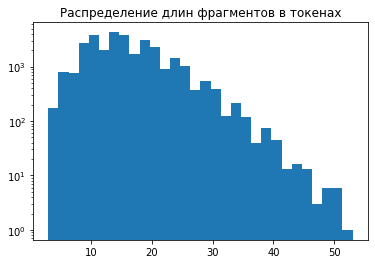

In [92]:
plt.hist([len(sent) for sent in train_token_ids], bins=30)
plt.title('Распределение длин фрагментов в токенах')
plt.yscale('log');

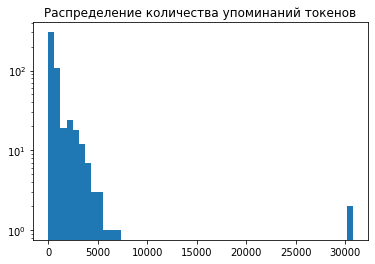

In [93]:
token_counts = np.bincount([token_id for text in train_token_ids for token_id in text])
plt.hist(token_counts, bins=50)
plt.title('Распределение количества упоминаний токенов')
plt.yscale('log');

In [96]:
unknown_subwords_in_test = sum(1 for text in test_token_ids for token_id in text if token_id == 1)
unknown_subwords_in_val = sum(1 for text in val_token_ids for token_id in text if token_id == 1)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке',
      unknown_subwords_in_test)
print('Количество случаев с неизвестными n-граммами символов в валидационной выборке',
      unknown_subwords_in_val)

Количество случаев с неизвестными n-граммами символов в валидационной выборке 0
Количество случаев с неизвестными n-граммами символов в валидационной выборке 3


In [97]:
from torch.utils.data import Dataset

In [99]:
train_token_ids[2]

[2,
 437,
 328,
 350,
 180,
 6,
 103,
 11,
 34,
 33,
 115,
 143,
 124,
 26,
 150,
 184,
 399,
 171,
 93,
 90,
 3]

In [100]:
import torch
from torch import nn
from torch.nn import functional as F

In [102]:
torch.tensor([2])

tensor([2])

In [105]:
train['Категория']

,name_norm,Категория
17365,соус барилла,"Соусы, орехи, консервы"
34637,пирожное эклеры крем брюле замороженное,Замороженные продукты
44625,конфеты молочного шоколада трюфельной начинк...,"Хлеб, сладости, снеки"
8452,гель душа малина пион женский цветочным аром...,"Красота, гигиена, бытовая химия"
21918,лосьон после бритья экстремальная свежесть,"Красота, гигиена, бытовая химия"
...,...,...
47301,"смесь молочная сухая гипоаллергенный """" питан...",Товары для мам и детей
46297,спрей ванной комнаты,"Красота, гигиена, бытовая химия"
27282,шоколад клубника йогуртом,"Хлеб, сладости, снеки"
5538,сушки кроха цельнозерновые,"Хлеб, сладости, снеки"


In [101]:
torch.tensor(train_token_ids[2])

tensor([  2, 437, 328, 350, 180,   6, 103,  11,  34,  33, 115, 143, 124,  26,
        150, 184, 399, 171,  93,  90,   3])

In [ ]:
class CatDataset(Dataset):
    def __init__(self, token_ids, labels):
        self.token_ids = token_ids
        self.labels = labels

    def __len__(self):
        return len(self.token_ids)

    def __getitem__(self, item):
        text = self.token_ids[item]
        start_i = random.randint(0, max(0, len(text) - self.chunk_length - 1))
        chunk = text[start_i : start_i + self.chunk_length + 1]

        seed_part = chunk[:-1]
        target_part = chunk[1:]

        seed_part = ensure_length(seed_part, self.chunk_length, self.pad_value)
        target_part = ensure_length(target_part, self.chunk_length, self.pad_value)

        seed_part = np.array(seed_part)
        target_part = np.array(target_part)

        return seed_part, target_part